##### Copyright 2021 Google LLC. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Colab for loading uniformly subsampled RLU Atari datasets such as 1%, 5% and 10% Atari datasets, as introduced by [Agarwal et al. (2020)](https://offline-rl.github.io/) and commonly used in offline RL research (e.g., CQL, Decision Transformer, MuZero ReAnalyze)


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://colab.research.google.com/github/google-research/rlds/blob/main/rlds/examples/tfds_rlu_atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Run In Google Colab"/></a>
  </td>
</table>

In [ ]:
#@title Install Pip packages
!pip install tfds-nightly
!pip install rlds[tensorflow]

In [ ]:
#@title Imports
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import functools
import numpy as np
import rlds
import tensorflow.compat.v2 as tf
import gc
import psutil
import math

In [ ]:
class BatchToTransition(object):
  """Creates (s,a,r,s',a') transitions."""

  def __init__(self, stack_size, update_horizon, gamma):
    self.stack_size = stack_size
    self.update_horizon = update_horizon
    self.total_frames = stack_size + update_horizon
    self.cumulative_discount = tf.pow(gamma, range(update_horizon))

  def create_transitions(self, batch):
    all_states = tf.squeeze(batch[rlds.OBSERVATION], axis=-1)
    all_states = tf.transpose(all_states, perm=[1, 2, 0])
    # all_states.set_shape((*all_states.shape[:2], stack_size + 1))
    rewards = batch[rlds.REWARD][self.stack_size-1:-1]
    terminals = batch[rlds.IS_TERMINAL][self.stack_size: self.total_frames]
    return {
        'states': all_states[:, :, :self.stack_size],
        'action': batch[rlds.ACTION][self.stack_size-1],
        'reward': tf.reduce_sum(rewards * self.cumulative_discount),
        'next_states': all_states[:, :, self.update_horizon:],
        'terminal': tf.reduce_any(terminals),
        'next_action': batch[rlds.ACTION][self.total_frames - 1],
    }

In [ ]:
def get_transition_dataset_fn(stack_size, update_horizon=1, gamma=0.99):
  batch_fn = BatchToTransition(
      stack_size, update_horizon, gamma).create_transitions
  def make_transition_dataset(episode):
    """Converts an episode of steps to a dataset of custom transitions."""
    # Create a dataset of 2-step sequences with overlap of 1.
    batched_steps = rlds.transformations.batch(
        episode[rlds.STEPS], size=stack_size+update_horizon, shift=1, drop_remainder=True)
    return batched_steps.map(batch_fn)
  return make_transition_dataset

def get_dummy_transition_dataset_fn():
  """Returns episode and checkpoint for checking how well shuffled a dataset is."""
  def make_transition_dataset(episode):
    """Converts an episode of steps to a dataset of ids."""
    # Create a dataset of 2-step sequences with overlap of 1.
    episode_info = tf.data.Dataset.from_tensors(
        (episode['episode_id'], episode['checkpoint_id'])).repeat()
    return episode_info
  return make_transition_dataset

In [ ]:
def uniformly_subsampled_atari_data(dataset_name, data_percent):
  ds_builder = tfds.builder(dataset_name)
  data_splits = []
  for split, info in ds_builder.info.splits.items():
    # Convert `data_percent` to number of episodes to allow
    # for fractional percentages.
    num_episodes = int((data_percent/100) * info.num_examples)
    if num_episodes == 0:
      raise ValueError(f'{data_percent}% leads to 0 episodes in {split}!')
    # Sample first `data_percent` episodes from each of the data split
    data_splits.append(f'{split}[:{num_episodes}]')
    # Interleave episodes across different splits/checkpoints
    # Set `shuffle_files=True` to shuffle episodes across files within splits
    read_config = tfds.ReadConfig(
        interleave_cycle_length=len(data_splits), 
        shuffle_reshuffle_each_iteration=True, 
        enable_ordering_guard=False)
  return tfds.load(dataset_name, split='+'.join(data_splits), 
                   read_config=read_config, shuffle_files=True)

In [ ]:
def create_atari_ds_loader(game, run_number, 
                           data_percent=10,
                           transition_fn=None,
                           shuffle_num_episodes=1000,
                           shuffle_num_steps=50000,
                           cycle_length=100):
  if transition_fn is None:
    transition_fn = get_transition_dataset_fn(4)
  dataset_name = f'rlu_atari_checkpoints_ordered/{game}_run_{run_number}'
  # Create a dataset of episodes sampling `data_percent`% episodes
  # from each of the data split 
  dataset = uniformly_subsampled_atari_data(dataset_name, data_percent)
  # Shuffle the episodes to avoid consecutive episodes
  dataset = dataset.shuffle(shuffle_num_episodes)
  # Interleave the steps across many different episodes
  dataset = dataset.interleave(
      transition_fn, cycle_length=cycle_length, block_length=1, 
      deterministic=False, num_parallel_calls=tf.data.AUTOTUNE)
  # Shuffle steps in the dataset
  shuffled_dataset = dataset.shuffle(
      shuffle_num_steps, reshuffle_each_iteration=True)
  return shuffled_dataset

In [ ]:
#@title Check that the episode and checkpoints are properly shuffled

shuffled_dataset = create_atari_ds_loader(
    'Pong', 1, transition_fn=get_dummy_transition_dataset_fn())

for i, x in enumerate(shuffled_dataset):
  print('Episode:', x[0].numpy(), 'Checkpoint:', x[1].numpy())
  if i > 100:
    break

Episode: 33 Checkpoint: 34
Episode: 41 Checkpoint: 11
Episode: 33 Checkpoint: 20
Episode: 43 Checkpoint: 20
Episode: 2 Checkpoint: 37
Episode: 32 Checkpoint: 5
Episode: 10 Checkpoint: 15
Episode: 46 Checkpoint: 46
Episode: 40 Checkpoint: 49
Episode: 0 Checkpoint: 42
Episode: 27 Checkpoint: 36
Episode: 13 Checkpoint: 2
Episode: 23 Checkpoint: 27
Episode: 27 Checkpoint: 5
Episode: 10 Checkpoint: 42
Episode: 41 Checkpoint: 36
Episode: 19 Checkpoint: 10
Episode: 16 Checkpoint: 11
Episode: 2 Checkpoint: 20
Episode: 19 Checkpoint: 45
Episode: 2 Checkpoint: 18
Episode: 9 Checkpoint: 11
Episode: 33 Checkpoint: 34
Episode: 0 Checkpoint: 11
Episode: 15 Checkpoint: 18
Episode: 23 Checkpoint: 27
Episode: 7 Checkpoint: 19
Episode: 32 Checkpoint: 46
Episode: 19 Checkpoint: 28
Episode: 6 Checkpoint: 36
Episode: 22 Checkpoint: 21
Episode: 34 Checkpoint: 42
Episode: 38 Checkpoint: 20
Episode: 41 Checkpoint: 36
Episode: 16 Checkpoint: 36
Episode: 38 Checkpoint: 20
Episode: 23 Checkpoint: 27
Episode: 4 C

In [ ]:
shuffled_dataset = create_atari_ds_loader('Pong', 1)
shuffled_dataset = shuffled_dataset.repeat().batch(32).prefetch(2)
iterator = shuffled_dataset.as_numpy_iterator()

In [ ]:
%%timeit
x1 = next(iterator)

100 loops, best of 5: 3.38 ms per loop


tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(32,), dtype=float32)


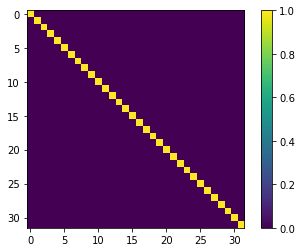

In [ ]:
x1 = next(iterator)
states = x1['states'][:, :, :, -1:]
next_states = x1['next_states'][:, :, :, -1:]
print(x1['reward'])

matrix = np.empty((len(states), len(states)))
for i, state in enumerate(states):
  for j, other_state in enumerate(states):
    matrix[i][j] = (np.equal(state, other_state)).all()
plt.imshow(matrix)
plt.colorbar()

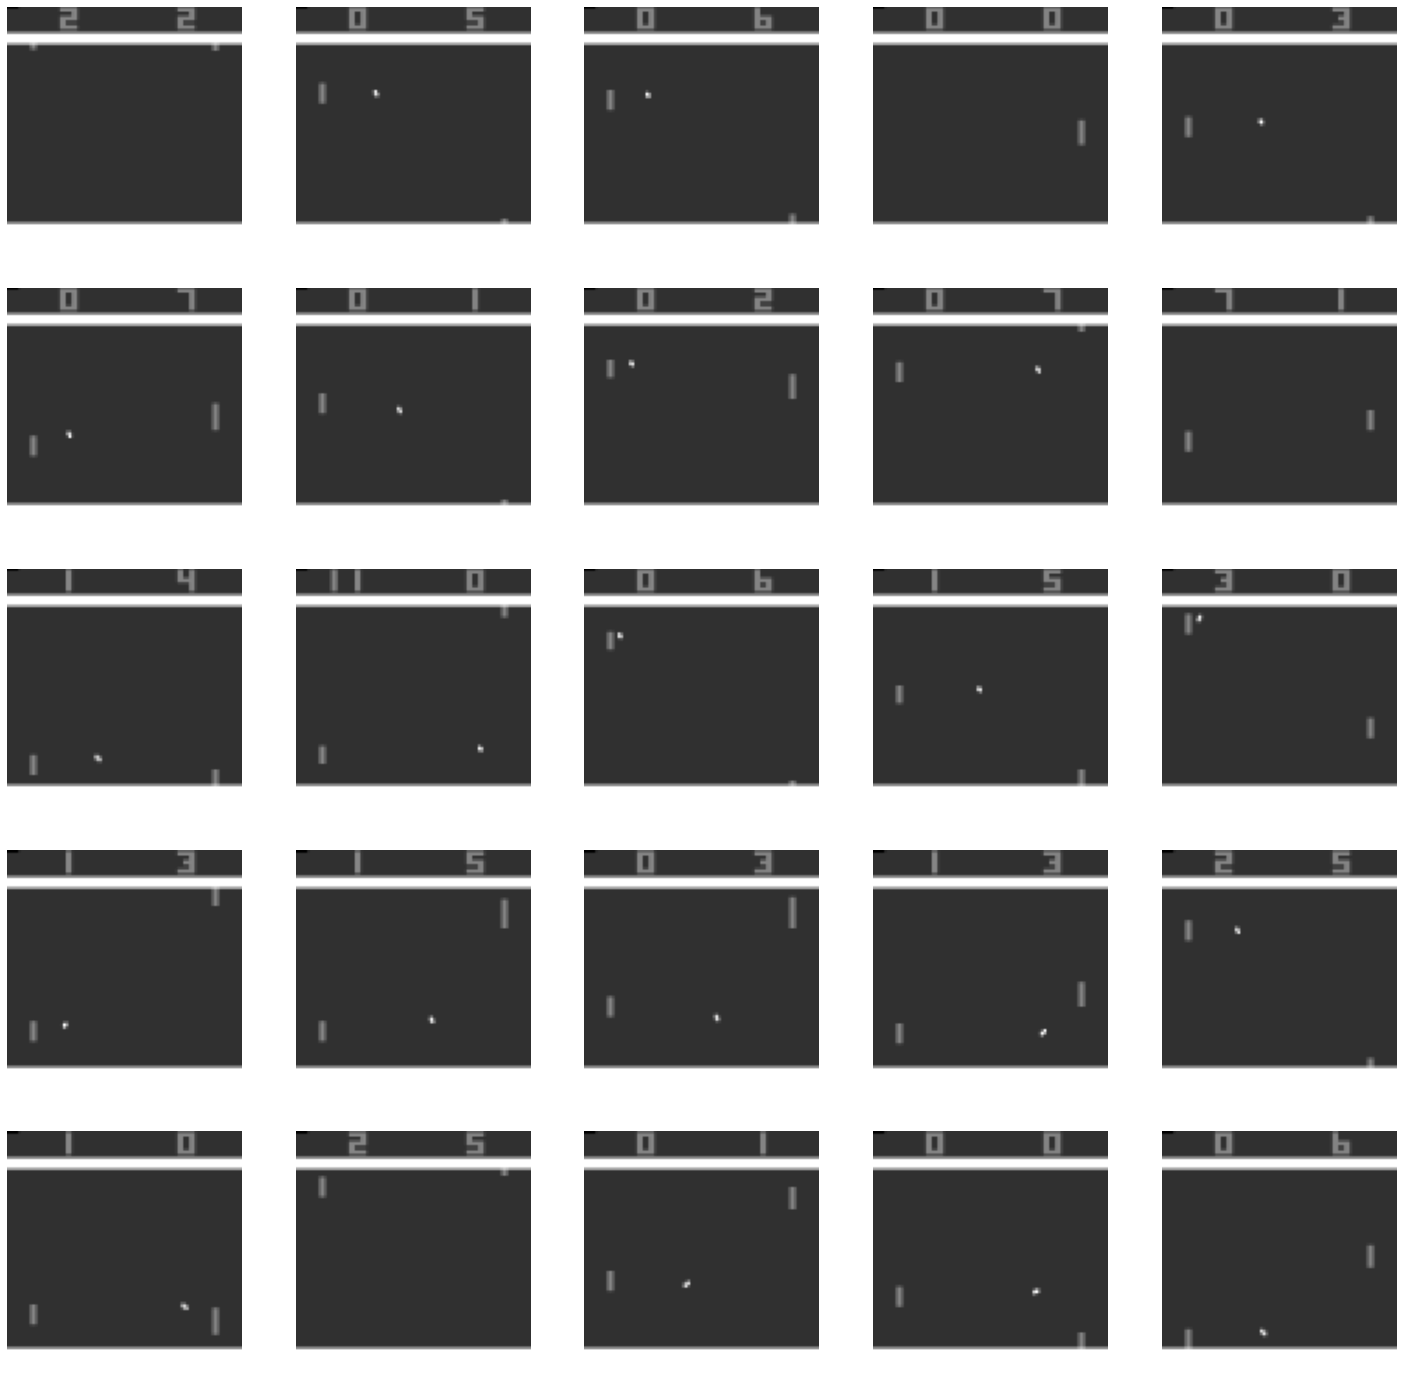

In [ ]:
total = len(states) 
ncols = 5
nrows = min(5, len(states) // ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
for id, data in enumerate(states):
  row, col = id // ncols, id % ncols
  if row >= nrows:
    break
  axes[row, col].imshow(data, cmap='gray')
  axes[row, col].set_axis_off()
plt.show()

##### Extra

In [ ]:
def get_num_episodes(ds, data_percent=10):
  num_steps_ds = ds.map(lambda episode: episode[rlds.STEPS].cardinality())
  num_steps_per_episode = list(num_steps_ds.as_numpy_iterator())

  cumulative_steps_per_episode = np.cumsum(num_steps_per_episode)
  dataset_size = int((data_percent/100) * sum(num_steps_per_episode)) 
  episode_id = np.searchsorted(
      cumulative_steps_per_episode, dataset_size, side='right')
  return episode_id + 1

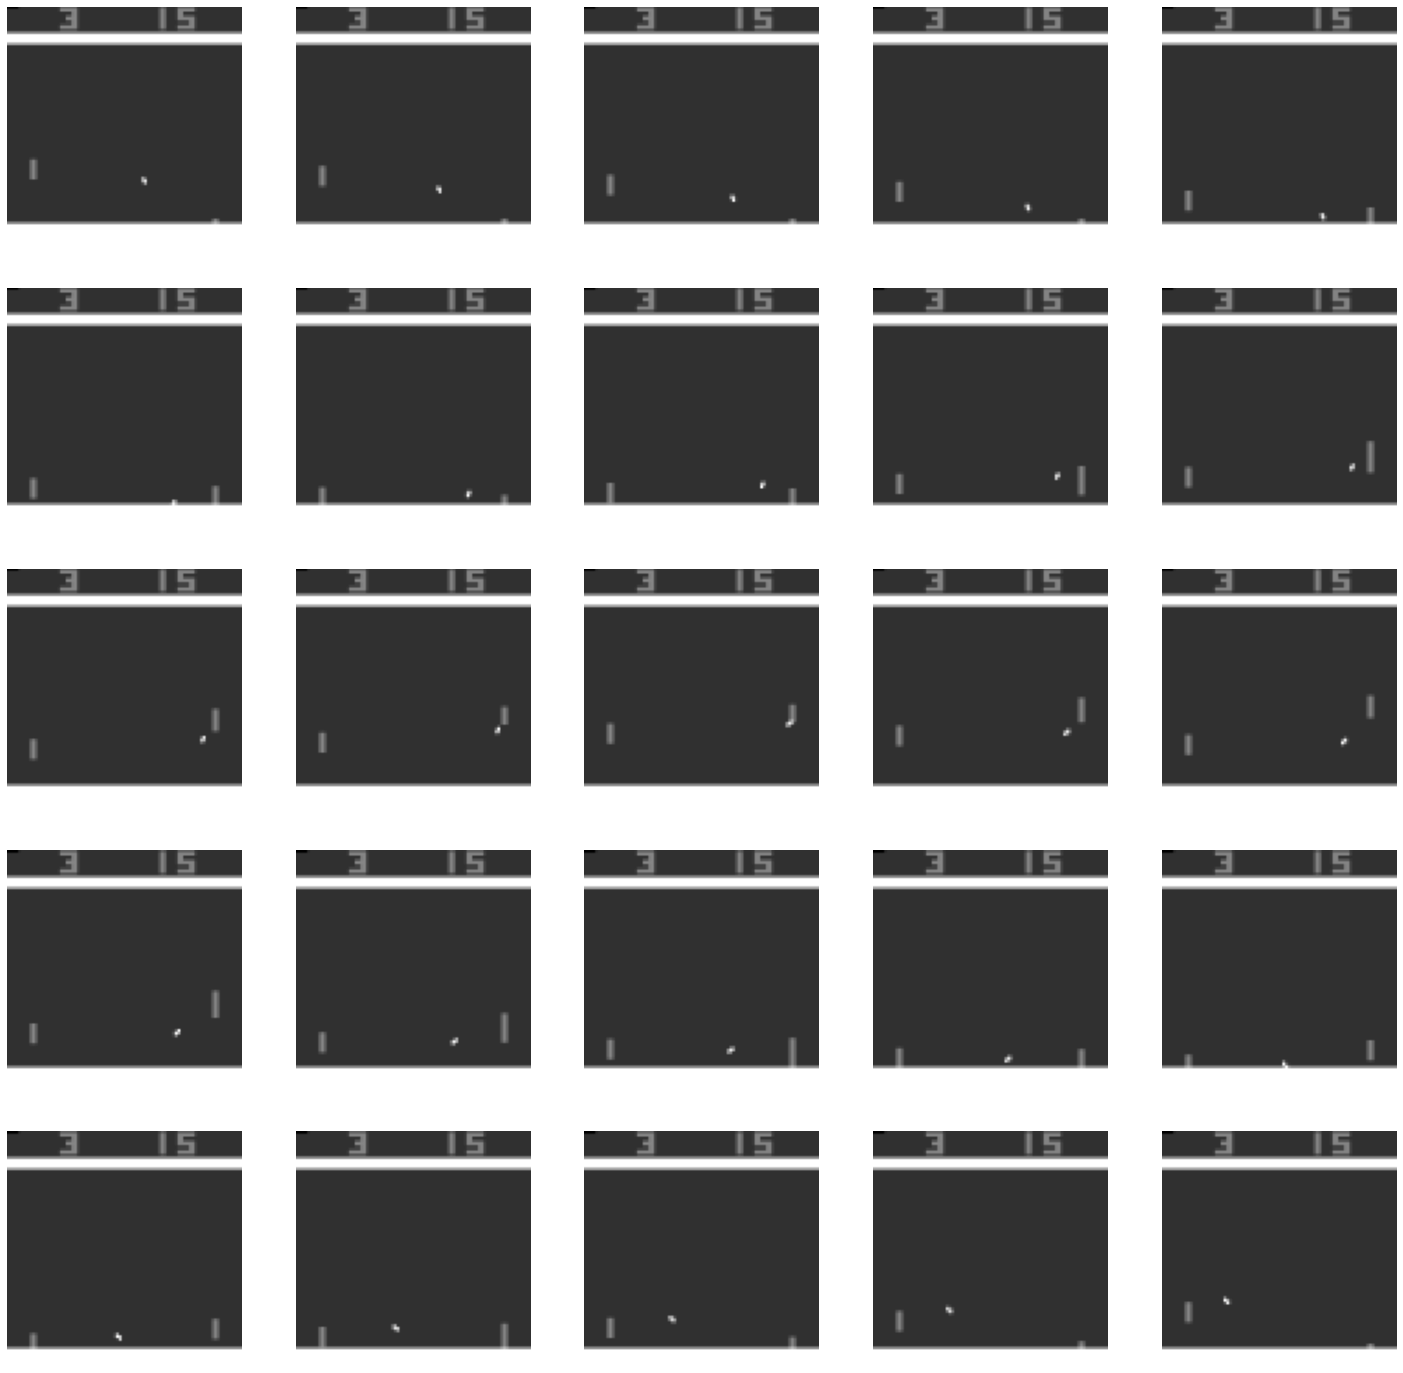

In [ ]:
ds = tfds.load('rlu_atari_checkpoints_ordered/Pong_run_1', split='checkpoint_49')
data = next(iter(ds))
dataset = list(iter(data['steps']))

total = len(dataset) 
ncols = 5
nrows = min(5, len(dataset) // ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
for id, data in enumerate(dataset):
  row, col = id // ncols, id % ncols
  if row >= nrows:
    break
  axes[row, col].imshow(data['observation'], cmap='gray')
  axes[row, col].set_axis_off()
plt.show()